In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dset_idx <- 1
# hub_con_thresh <- 0.25
hub_con_thresh <- 0.0

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
cancer_name <- c("cervical cancer", "none", "endometrial cancer")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [4]:
matrisome_df <- rutils::load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category) %>%
    dplyr::rename(geneID = gene_symbol)
deseq_df <- read_tsv(paste0(dirs$analysis_dir, "/deg/", unified_dsets[dset_idx], "_DESeq_results.tsv")) %>%
    rename(base_mean = baseMean, lfc = log2FoldChange) %>%
    mutate(change_dir = ifelse(lfc > 0, "up", "down")) %>%
    select(geneID, change_dir, base_mean, lfc, qval)

demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))

figo_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_umsmg_list.txt"))
figo_nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_nsmg_list.txt"))
figo_list <- figo_umsmg_list %>%
    union(figo_nsmg_list) %>%
    intersect(demg_list)

survival_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_survival_umsmg_list.txt"))
survival_list <- survival_umsmg_list %>%
    intersect(demg_list)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)




In [5]:
pathology_df <- read_tsv(paste0(dirs$data_dir, "/THPA_v20_1_staining/pathology.tsv")) %>%
    rename_all(tolower) %>%
    rename_with(~ gsub(" - ", "_", .x, fixed = TRUE)) %>%
    rename_with(~ gsub(" ", "_", .x, fixed = TRUE)) %>%
    rename(geneID = gene_name) %>%
    select(geneID, cancer, high, medium, low, not_detected) %>%
    filter(cancer %in% cancer_name[dset_idx]) %>%
    filter(rowSums(is.na(.[,3:6])) == 0) %>%
    dplyr::mutate(
        detected_count = rowSums(.[c("high", "medium", "low")]),
        detected_prop = detected_count / (not_detected + detected_count),
        detected = detected_count > 0
    )

count_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/counts.tsv")) %>%
    select(-Entrez_Gene_Id) %>%
    rename(geneID = Hugo_Symbol)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Gene = col_character(),
  `Gene name` = col_character(),
  Cancer = col_character(),
  High = col_double(),
  Medium = col_double(),
  Low = col_double(),
  `Not detected` = col_double(),
  `prognostic - favorable` = col_double(),
  `unprognostic - favorable` = col_double(),
  `prognostic - unfavorable` = col_double(),
  `unprognostic - unfavorable` = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Hugo_Symbol = col_character()
)
i Use `spec()` for the full column specifications.




In [6]:
gene_count_quantiles <- rowMeans(count_df[, -1]) %>%
    quantile()

high_count_genes <- count_df %>%
    filter(rowMeans(.[, -1]) > gene_count_quantiles["25%"]) %>%
    pull(geneID)

In [7]:
stat_df <- pathology_df %>%
    mutate(
        all = TRUE,
        mat = geneID %in% matrisome_df$geneID,
        de = geneID %in% demg_list,
        figo_sig = geneID %in% figo_list,
        survival_sig = geneID %in% survival_list,
        detected_f = factor(ifelse(detected, "yes", "no"))
    ) %>%
    filter(geneID %in% high_count_genes)
    

sig_pivot_stat_df <- stat_df %>%
    pivot_longer(cols = c("all", "mat", "de", "figo_sig", "survival_sig"), names_to = "group", values_to = "group_val") %>%
    dplyr::filter(group_val == TRUE) %>%
    # All TRUE so don't need
    dplyr::select(-group_val) %>%
    dplyr::mutate(group_f = factor(group, levels = c("all", "mat", "de", "figo_sig", "survival_sig")))


In [8]:
stat_df %>%
    inner_join(matrisome_df, by = "geneID") %>%
    group_by(category) %>%
    summarize(pct_detected = sum(detected) / n(), n_genes = n())

,category,pct_detected,n_genes
,<chr>,<dbl>,<int>
1,Collagens,0.7037037,27
2,ECM Glycoproteins,0.7096774,124
3,ECM Regulators,0.7664234,137
4,ECM-affiliated Proteins,0.7064220,109
5,Proteoglycans,0.7222222,18
6,Secreted Factors,0.7333333,150


# Vis.

In [9]:
bp_stat_df <- sig_pivot_stat_df %>%
    mutate(group_f = factor(
        group_f,
        labels = c("all" = "All", "mat" = "Mat.", "de" = "DEM", "figo_sig" = "FIGO sig.", "survival_sig" = "Survival sig."))
    ) %>%
    group_by(group_f) %>%
    summarize(
        pct_genes_det = sum(detected) / n() * 100,
        pct_genes_n_det = 100 - pct_genes_det,
        n = n(),
    ) %>%
    pivot_longer(
        cols = c("pct_genes_det", "pct_genes_n_det"),
        names_to = "det_group",
        values_to = "pct",
    ) %>%
    mutate(
        det_group_f = factor(det_group, labels = c("pct_genes_n_det" = "% not det.", "pct_genes_det" = "% det."), levels = c("pct_genes_n_det", "pct_genes_det")),
        n_genes = 1/100 * pct * n
    ) %>%
    select(-n)

# bp_stat_df

Saving 6.67 x 6.67 in image



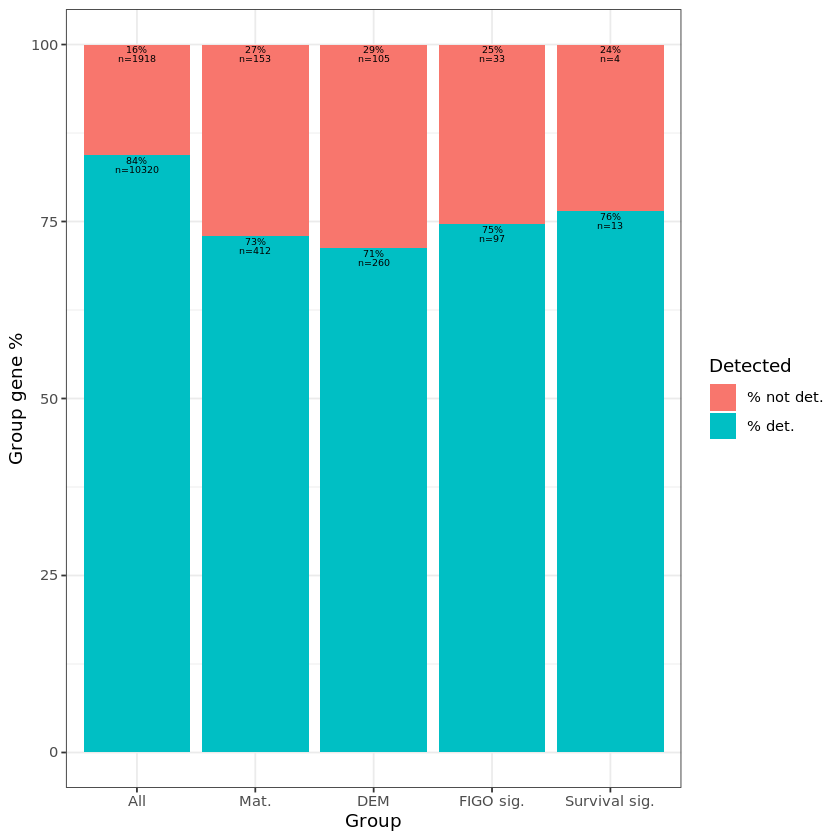

In [10]:
ggplot(data = bp_stat_df, aes(x = group_f, y = pct)) +
    geom_col(aes(fill = det_group_f)) +
    geom_text(aes(label = paste0(round(pct), "%")), position = "stack", vjust = 1.25, size = 2) +
    geom_text(aes(label = paste0("n=", n_genes)), position = "stack", vjust = 2.5, size = 2) +
    labs(x = "Group", y = "Group gene %", fill = "Detected") +
    theme_bw() +
ggsave(paste0(dirs$figures_dir, "/one_off/", unified_dsets[dset_idx], "_detection_bar_plot.png"))

In [11]:
bp2_df <- sig_pivot_stat_df %>%
    mutate(n_samp = not_detected + detected_count) %>%
    select(geneID, group_f, high, medium, low, not_detected, n_samp) %>%
    pivot_longer(cols = c("high", "medium", "low", "not_detected"), names_to = "detection_level", values_to = "detection_count") %>%
    mutate(
        detection_level = factor(detection_level, levels = c("high", "medium", "low", "not_detected"), labels = c("high", "medium", "low", "not detected")),
        group_f = factor(group_f, labels = c("all" = "All", "mat" = "Mat.", "de" = "DEM", "figo_sig" = "FIGO sig.", "survival_sig" = "Survival sig."))
    ) %>%
    group_by(group_f, detection_level) %>%
    summarize(level_count = sum(detection_count), n_genes = n(), n_samps = sum(n_samp), pct_samp = level_count / n_samps * 100)
# bp2_df

`summarise()` has grouped output by 'group_f'. You can override using the `.groups` argument.



Saving 6.67 x 6.67 in image



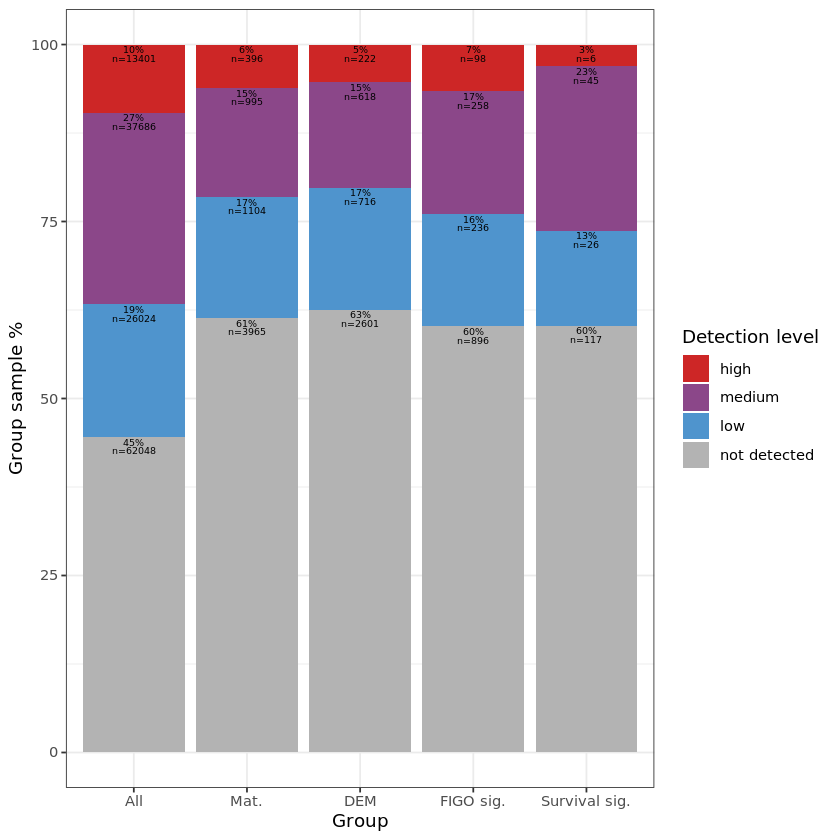

In [12]:
color_vals = c("low" = "steelblue3", "medium" = "orchid4", "high" = "firebrick3", "not detected" = "gray70")

ggplot(data = bp2_df, aes(x = group_f, y = pct_samp, group = detection_level)) +
    geom_col(aes(fill = detection_level)) +
    geom_text(aes(label = paste0(round(pct_samp), "%")), position = "stack", vjust = 1.25, size = 2) +
    geom_text(aes(label = paste0("n=", level_count)), position = "stack", vjust = 2.5, size = 2) +
    scale_fill_manual(values = color_vals) +
    labs(x = "Group", y = "Group sample %", fill = "Detection level") +
    theme_bw()
ggsave(paste0(dirs$figures_dir, "/one_off/", unified_dsets[dset_idx], "_detection_level_bar_plot.png"))

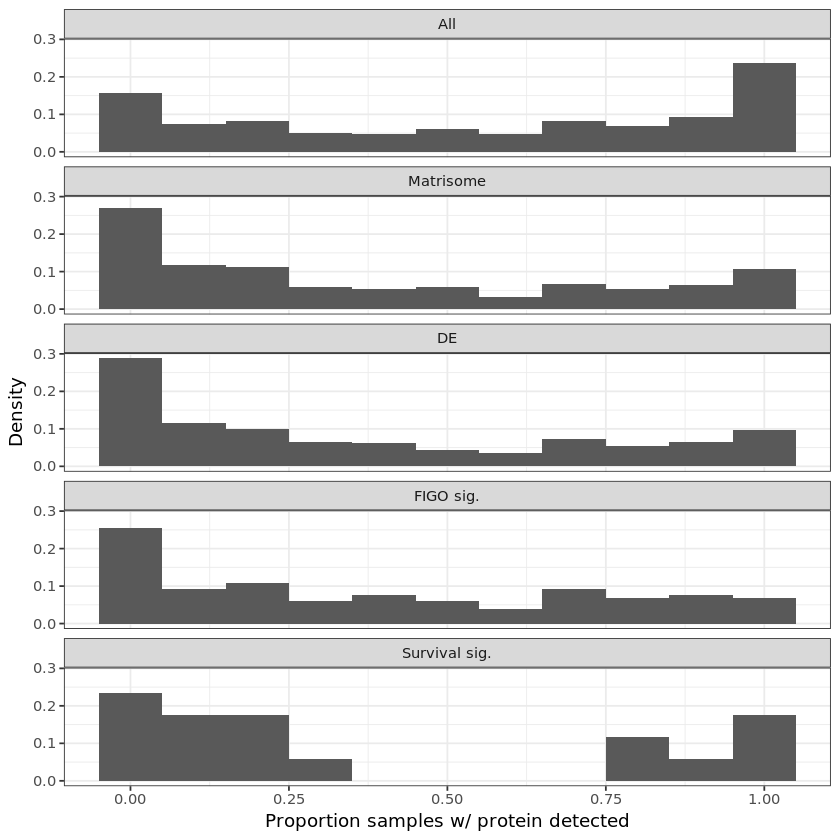

In [13]:
bin_wid <- 0.1
ggplot(aes(x = detected_prop), data = sig_pivot_stat_df) +
    geom_histogram(aes(y = ..density.. * bin_wid), position = , binwidth = bin_wid) +
    facet_wrap(~ group_f, nrow = 5, labeller = as_labeller(c("all" = "All", "mat" = "Matrisome", "de" = "DE", "figo_sig" = "FIGO sig.", "survival_sig" = "Survival sig."))) +
    theme_bw() +
labs(x = "Proportion samples w/ protein detected", y = "Density")

# Tests

## Include "all" category

In [14]:
oneway.test(detected_prop ~ group_f, data = sig_pivot_stat_df)


	One-way analysis of means (not assuming equal variances)

data:  detected_prop and group_f
F = 52.807, num df = 4.00, denom df = 107.89, p-value < 2.2e-16


In [15]:
det_tab <- table(sig_pivot_stat_df$detected_f, sig_pivot_stat_df$group_f)
det_tab

     
        all   mat    de figo_sig survival_sig
  no   1918   153   105       33            4
  yes 10320   412   260       97           13

In [16]:
chisq.test(det_tab)

Warning message in chisq.test(det_tab):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  det_tab
X-squared = 99.188, df = 4, p-value < 2.2e-16


## Remove "all" category

In [17]:
mat_sig_pivot_stat_df <- sig_pivot_stat_df %>%
    filter(group_f != "all") %>%
    mutate(group_f = factor(as.character(group_f), levels = c("mat", "de", "figo_sig", "survival_sig")))

In [18]:
oneway.test(detected_prop ~ group_f, data = mat_sig_pivot_stat_df)


	One-way analysis of means (not assuming equal variances)

data:  detected_prop and group_f
F = 0.14556, num df = 3.000, denom df = 73.002, p-value = 0.9322


In [19]:
mat_det_tab <- table(mat_sig_pivot_stat_df$detected_f, mat_sig_pivot_stat_df$group_f)
mat_det_tab

     
      mat  de figo_sig survival_sig
  no  153 105       33            4
  yes 412 260       97           13